In [10]:
pip install -r requirements.txt 

  Using cached aiohttp-3.8.5-cp39-cp39-macosx_11_0_arm64.whl (345 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached appnope-0.1.3-py2.py3-none-any.whl (4.4 kB)
  Using cached asttokens-2.2.1-py2.py3-none-any.whl (26 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached attrs-22.2.0-py3-none-any.whl (60 kB)
  Using cached blobfile-2.0.1-py3-none-any.whl (73 kB)
  Using cached bs4-0.0.1.tar.gz (1.1 kB)
  Using cached certifi-2023.7.22-py3-none-any.whl (158 kB)
  Using cached charset_normalizer-2.1.1-py3-none-any.whl (39 kB)
  Using cached comm-0.1.2-py3-none-any.whl (6.5 kB)
  Using cached contourpy-1.0.7-cp39-cp39-macosx_11_0_arm64.whl (229 kB)
  Using cached debugpy-1.6.5-py2.py3-none-any.whl (4.9 MB)
  Using cached docopt-0.6.2.tar.gz (25 kB)
  Using cached executing-1.2.0-py2.py3-none-any.whl (24 kB)
  Using cached filelock-3.9.0-py3-none-any.whl (9.7 kB)
  Using cached frozenlist-1.3.3-cp39-cp39-macosx_11_0_arm64.whl (35 kB)
  Usin

  Using cached urllib3-1.26.13-py2.py3-none-any.whl (140 kB)
  Using cached yarg-0.1.9-py2.py3-none-any.whl (19 kB)
  Using cached yarl-1.8.2-cp39-cp39-macosx_11_0_arm64.whl (57 kB)
  Using cached safetensors-0.4.1-cp39-cp39-macosx_11_0_arm64.whl (426 kB)
  Using cached fsspec-2023.12.2-py3-none-any.whl (168 kB)
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=040a2737c0a92b3acef6760730824519c22457a3959b1bf90c093cf3d256ade0
  Stored in directory: /Users/terencetsuiholung/Library/Caches/pip/wheels/73/2b/cb/099980278a0c9a3e57ff1a89875ec07bfa0b6fcbebb9a8cad3
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=a94ddabfcfe287b2d082daef9a72b552fee0279941e64469d4e4870637e8e465
  Stored in directory: /Users/terencetsuiholung/Library/Caches/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
  Created wheel for lxml: filename=lxml-4.9.2-cp39-cp39-macosx_11_0_arm64.whl size=1471235 sha256=9b5100b71130381e0a23a7b

Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "openai.com"
full_url = "https://openai.com/"

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))


def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

https://openai.com/
https://openai.com/pricing
https://openai.com/policies/usage-policies
https://openai.com/policies/usage-policies#content
https://openai.com/api/policies/sharing-publication
https://openai.com/policies/sharing-publication-policy#content
https://openai.com/form/researcher-access-program
https://openai.com/form/researcher-access-program#content
https://openai.com/policies/sharing-publication-policy#research
https://openai.com/policies/terms-of-use
https://openai.com/policies/business-terms
https://openai.com/policies/business-terms#content
https://openai.com/policies/aug-2023-business-terms
https://openai.com/policies/api-data-usage-policies
https://openai.com/enterprise-privacy#content
https://openai.com/blog/bug-bounty-program
https://openai.com/careers/search?c=security
https://openai.com/careers/sales-engineer-dublin
https://openai.com/careers/sales-engineer-dublin#content
https://openai.com/careers/search
https://openai.com/careers/data-scientist-product
https://o

https://openai.com/blog/openai-announces-leadership-transition#content
https://openai.com/blog/openai-announces-leadership-transition#OpenAI
https://openai.com/blog/dall-e-3-is-now-available-in-chatgpt-plus-and-enterprise
https://openai.com/blog/dall-e-3-is-now-available-in-chatgpt-plus-and-enterprise#content
https://openai.com/blog/dall-e-3-is-now-available-in-chatgpt-plus-and-enterprise#OpenAI
https://openai.com/blog?topics=research
https://openai.com/blog/sam-altman-returns-as-ceo-openai-has-a-new-initial-board
https://openai.com/blog/sam-altman-returns-as-ceo-openai-has-a-new-initial-board#content
https://openai.com/blog/sam-altman-returns-as-ceo-openai-has-a-new-initial-board#OpenAI
https://openai.com/blog/gpt-3-5-turbo-fine-tuning-and-api-updates
https://openai.com/blog?authors=andrew-peng
https://openai.com/blog?authors=michael-wu
https://openai.com/blog/gpt-3-5-turbo-fine-tuning-and-api-updates#content
https://openai.com/blog?authors=john-allard
https://openai.com/blog/gpt-3-5-

https://openai.com/research/generalizing-from-simulation
https://openai.com/research/generalizing-from-simulation#content
https://openai.com/research?authors=lerrel-pinto
https://openai.com/research?authors=pieter-abbeel
https://openai.com/research?authors=xue-bin-peng
https://openai.com/blog/generalizing-from-simulation/#pusher_fail
https://openai.com/research?topics=meta-learning
https://openai.com/research?topics=domain-randomization
https://openai.com/research?authors=ben-barry
https://openai.com/research?topics=robotics
https://openai.com/research?topics=sim-to-real
https://openai.com/research?authors=jonas-schneider
https://openai.com/research?authors=wojciech-zaremba
https://openai.com/research/openai-five#exploration
https://openai.com/research/competitive-self-play
https://openai.com/research?authors=trapit-bansal
https://openai.com/research/competitive-self-play#content
https://openai.com/research?authors=igor-mordatch
https://openai.com/research?topics=environments
https://o

https://openai.com/research/debate
https://openai.com/research/debate#content
https://openai.com/research/gpt-2-6-month-follow-up
https://openai.com/blog/better-language-models/#update
https://openai.com/research/gpt-2-6-month-follow-up#content
https://openai.com/research?authors=daniel-ziegler
https://openai.com/research?authors=tom-brown
https://openai.com/research/learning-complex-goals-with-iterated-amplification
https://openai.com/research?authors=geoffrey-irving
https://openai.com/research/fine-tuning-gpt-2#content
https://openai.com/research?authors=nisan-stiennon
https://openai.com/blog/deep-reinforcement-learning-from-human-preferences
https://openai.com/blog/deep-reinforcement-learning-from-human-preferences/#bflip
https://openai.com/research/learning-from-human-preferences#content
https://openai.com/research?models=gpt-3
https://openai.com/research?authors=suchir-balaji
https://openai.com/research?authors=jacob-hilton
https://openai.com/blog/webgpt/#rf4
https://openai.com/re

https://openai.com/blog/introducing-chatgpt-enterprise#content
https://openai.com/blog/chatgpt-plugins
https://openai.com/bot
HTTP Error 403: Forbidden
https://openai.com/research/webgpt
https://openai.com/blog/chatgpt-plugins#OpenAI
https://openai.com/blog/chatgpt-plugins#content
https://openai.com/blog/planning-for-agi-and-beyond
https://openai.com/blog/critiques
https://openai.com/blog/planning-for-agi-and-beyond#content
https://openai.com/blog/planning-for-agi-and-beyond#SamAltman
http://openai.com/waitlist/plugins
https://openai.com/waitlist/plugins#content
https://openai.com/waitlist/plugins
https://openai.com/blog/introducing-chatgpt-enterprise#OpenAI
https://openai.com/blog/introducing-gpts
https://openai.com/blog/openai-partners-with-scale-to-provide-support-for-enterprises-fine-tuning-models
https://openai.com/blog/openai-partners-with-scale-to-provide-support-for-enterprises-fine-tuning-models#OpenAI
https://openai.com/blog/openai-partners-with-scale-to-provide-support-for-e

https://openai.com/blog?authors=john-schulman-2
https://openai.com/blog/our-approach-to-alignment-research#JeffreyWu
https://openai.com/blog/openai-codex
https://openai.com/blog/openai-codex#GregBrockman
https://openai.com/blog/openai-codex#WojciechZaremba
https://openai.com/blog/openai-codex#OpenAI
https://openai.com/blog/openai-codex#content
https://openai.com/blog?authors=jeffrey-wu
https://openai.com/blog/our-approach-to-alignment-research#JohnSchulman
https://openai.com/blog/our-approach-to-alignment-research#JanLeike
https://openai.com/blog/instruction-following/#limitations
https://openai.com/blog?authors=jan-leike
https://openai.com/blog/our-approach-to-alignment-research#content
https://openai.com/blog/introducing-superalignment
https://openai.com/blog/introducing-superalignment#JanLeike
https://openai.com/blog/introducing-superalignment#content
https://openai.com/careers/research-manager-superalignment
HTTP Error 404: Not Found
https://openai.com/blog/introducing-superalignme

https://openai.com/careers/engineering-manager-ai-inference-systems#content
https://openai.com/careers/software-engineer-infrastructure-2
https://openai.com/careers/software-engineer-infrastructure-2#content
https://openai.com/careers/software-engineer-model-inference-2
https://openai.com/careers/software-engineer-model-inference-2#content
https://openai.com/careers/senior-software-engineer-data-acquisition
https://openai.com/careers/senior-software-engineer-data-acquisition#content
https://openai.com/careers/applied-engineering-head-of-data-engineering
https://openai.com/careers/applied-engineering-head-of-data-engineering#content
https://openai.com/careers/national-security-threat-researcher
https://openai.com/careers/national-security-threat-researcher#content
https://openai.com/careers/software-engineer-safety
https://openai.com/careers/software-engineer-safety#content
https://openai.com/careers/media-relations-api-communications
https://openai.com/careers/media-relations-api-commu

https://openai.com/blog/the-international-2018-results
https://openai.com/research/the-international-2018-results#content
https://openai.com/research/the-international-2018-results#rules-change
https://openai.com/five/#overview
https://openai.com/blog/openai-five-finals#content
https://openai.com/research/openai-five-defeats-dota-2-world-champions#replays
https://openai.com/research/openai-five-benchmark-results#training
https://openai.com/research/retro-contest-results
https://openai.com/research/retro-contest-results#content
https://openai.com/research?authors=vicki-pfau
https://openai.com/blog/retro-contest
https://openai.com/research/retro-contest#content
https://openai.com/research/openai-five#our-approach
https://openai.com/research/more-on-dota-2#bot-exploits
https://openai.com/research/learning-dexterity
https://openai.com/blog/jukebox/#rf33
https://openai.com/research/emergent-tool-use
https://openai.com/research?authors=todor-markov
https://openai.com/blog/competitive-self-pl

In [2]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [3]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

/var/folders/dx/942l9g7s23b3wvb64nkf4yrw0000gn/T/ipykernel_80889/2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,research?authors=henk tillman,research?authors=henk tillman. Research index...
1,research?authors=arthur petron,research?authors=arthur petron. Research inde...
2,dall e 3#content,dall e 3#content. DALL·E 3 CloseSearch Sub...
3,policies service credit terms,policies service credit terms. Service credit...
4,research roboschool#content,research roboschool#content. Roboschool Cl...


In [5]:
pip install tiktoken


     |████████████████████████████████| 955 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 291 kB 702 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


<AxesSubplot:>

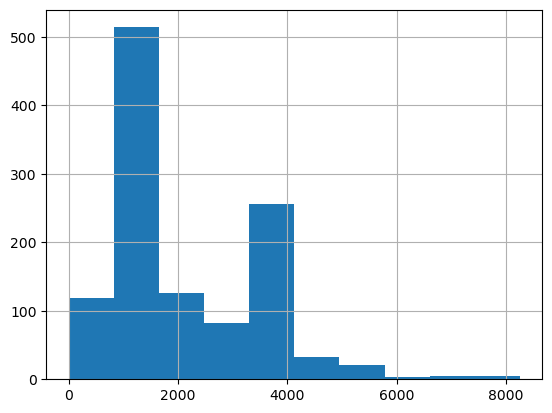

In [6]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [7]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    # Add the last chunk to the list of chunks
    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

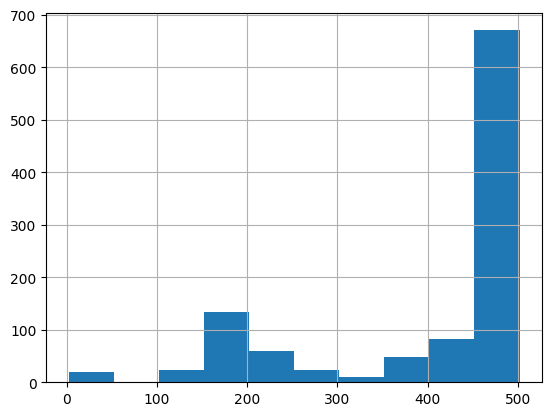

In [28]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [19]:
import openai
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()

NameError: name 'sk' is not defined

In [9]:
import pandas as pd
import numpy as np
from ast import literal_eval
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(literal_eval).apply(np.array)

df.head()

ModuleNotFoundError: No module named 'openai'

In [32]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

'No, you are not allowed to publish model outputs to Twitter without a human review. You must manually review each generation before sharing or while streaming, and indicate that the content is AI-generated in a way no user could reasonably miss or misunderstand.'

In [33]:
answer_question(df, question="What day is it?", debug=False)

"I don't know."

In [34]:
answer_question(df, question="What is our newest embeddings model?")

'The newest embeddings model is text-embedding-ada-002.'